# Seismic deconvolution: one problem, many (possible) solutions

**Authors: M. Ravasi, N. Luiken, KAUST**

Welcome to our first tutorial at Transform2022!

The aim of this tutorial is to 

- Discuss a well-known and well-studied problem in signal processing (and geophysics), namely *wavelet deconvolution*;
- Showcase a number of alternative solutions discussing their pros and cons;
- As a by-product of the above, show how different libraries in the Python ecosystem (e.g., NumPy/SciPy, PyLops, PyProximal, PyTorch) can be used to solve such a problem in alternative ways.

## Useful links

- Tutorial Github repository: https://github.com/PyLops/pylops_transform2022
        
- PyLops Github repository: https://github.com/PyLops/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

- PyProximal Github repository: https://github.com/PyLops/pyproximal

- PyProximal reference documentation: https://pyproximal.readthedocs.io/en/latest/

- PyTorch reference documentation: https://pytorch.org

## Theory in a nutshell

In this tutorial we will try to keep the theory to a minimum and quickly expose you to practical examples. Some of the blocks will be deliberately skipped, feel free to go over them in your own time if interested to deep diver into the theoretical aspects of this tutorial!

However, we want to make sure that some of the basic underlying concepts are clear to everyone and define a common mathematical notation.

The problem that we wish to solve can be simply written as follows:

$$
d(t) = w(t) * r(t) + n(t) 
$$

where $r(t)$ is a given input signal (sometimes referred to as reflectivity), $w(t)$ is a known wavelet, d(t) is the
given data and $n(t)$ is the noise.

The goal of wavelet deconvolution (or seismic deconvolution) is to retrieve the reflectivity from the noisy measurements given knowledge of the wavelet.

<img src="figs/Convmodel.png" width="800">

We will consider the following possible ways of solving this problem:

- frequency-domain deconvolution
- time-domain deconvolution via least-squares inversion
- time-domain deconvolution via sparse inversion
- time-domain deconvolution via autograd-style inversion
- time-domain deconvolution with deep-image-prior style preconditioner
- data-driven deconvolution

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries and get .py files from the repository of the tutorial)
# !git clone https://github.com/PyLops/pylops_transform2022.git
# !pip install pylops==1.18.0 pylops-gpu pyproximal
# !cp pylops_transform2022/*py .
# !rm -rf pylops_transform2022

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylops
import pyproximal
import torch
import torch.nn as nn
import scipy as sp

from IPython.core.display import HTML
from scipy.sparse.linalg import lsqr
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from pylops.utils.wavelets import ricker
from pylops.utils import dottest
from pylops.optimization.solver import lsqr as lsqr_pylops
from pylops_gpu import TorchOperator
from datadriven import *
from afista import AFISTA

In [3]:
# Center figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
# Set random seed (this is done to ensure the noise added to the data is always the same)
np.random.seed(0)

## Data creation

Let's now get started. First of all we will create the reflectivity $r(t)$ that we will be using during the entire tutorial. It is composed of 3 events with different amplitude and polarity.

We then create the convolutional operator using PyLops `Convolve1D`. We will see that this comes handy both we perform inversion in a model-driven fashion as well as a way to easily create data when we approach deconvolution in a data-driven manner.

Finally, to really compare the robustness of various methods we also create and add some noise to the data.

Dot test passed, v^T(Opu)=-16.139280 - u^T(Op^Tv)=-16.139280


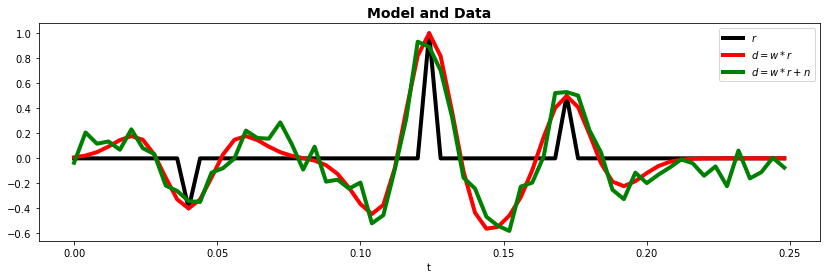

In [5]:
# Model
nt = 63 # this needs to be a odd number to ensure symmetric wavelet in the frequency domain approach
dt = 0.004
f0 = 20

t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

# Operator
h, th, hcenter = pylops.utils.wavelets.ricker(t, f0=f0)
Cop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
dottest(Cop, verb=True)

# Data
y = Cop * x
yn = y + np.random.normal(0, 0.1, y.shape)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$r$")
ax.plot(t, y, "r", lw=4, label=r"$d=w*r$")
ax.plot(t, yn, "g", lw=4, label=r"$d=w*r + n$")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold")
ax.legend();

## Frequency domain decon

Convolution in the time domain is equivalent to a multiplication in the frequency domain. 

$$
\hat{d}(\omega) = \hat{w}(\omega) \cdot \hat{r}(\omega) 
$$

Therefore, by applying a Fourier transform to all of our signals, we obtain an estimate of the solution by simple pointwise division:

$$
\hat{r}(\omega) = \frac{\hat{d}(\omega) }{\hat{w}(\omega) }.
$$

The reflectivity is obtained by applying an inverse Fourier transform to go back to the time domain. Because the wavelet $w$ is bandlimited, we expect certain frequencies to be 0. To achieve this, we may introduce a frequency filter $\varphi_{\lambda}$
$$
\hat{r}(\omega) = \frac{1}{\varphi_{\lambda}\left(\hat{w}(\omega)\right)}\hat{d}(\omega),
$$
where $\lambda$ is a certain threshold.

Popular choices of $\varphi_{\lambda}$ are
$$
\begin{align}
    & \varphi_{\lambda}(x) = \frac{1}{x + \lambda} \\
    & \varphi_{\lambda}(x) = \frac{x^*}{x^2 + \lambda} \\
    & \varphi_{\lambda}(x) = \begin{cases} x \text{ if } x > \lambda \\ 0 \text{ if } x < \lambda \end{cases}\\
\end{align}
$$

In this example, we will use the first one.

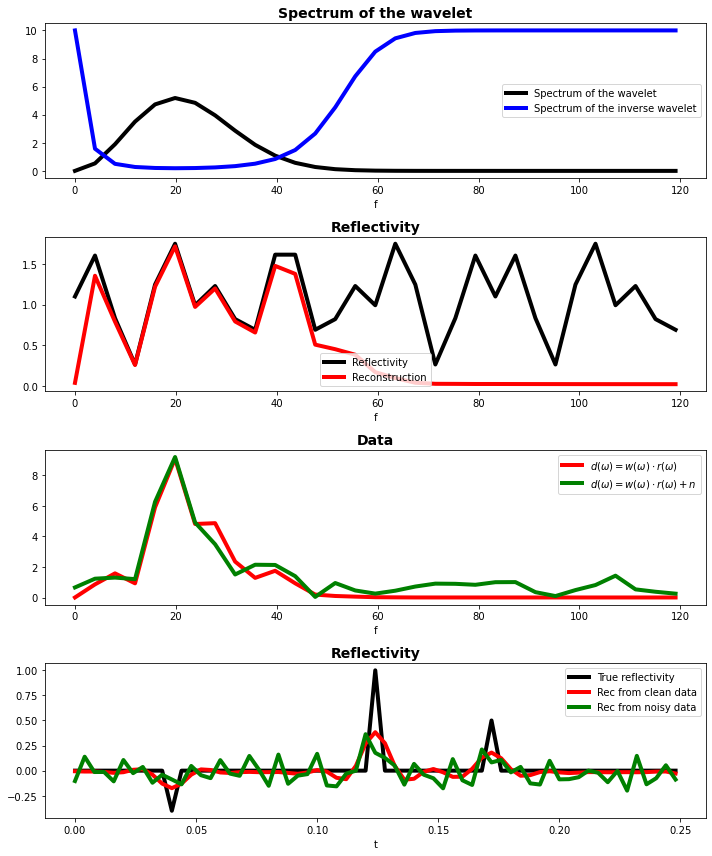

In [6]:
hfilt =  h[nt//2:3*nt//2] # this is the centered filter

# Fourier transform
nfft = nt
f = np.fft.fftfreq(nfft, dt)
hF  = np.fft.fft(np.fft.ifftshift(hfilt))
xF  = np.fft.fft(x)
yF  = np.fft.fft(y)
ynF = np.fft.fft(yn)

# Deconvolution in frequency domain
xfF = yF / (hF + 1e-1)
xfnF = ynF / (hF + 8e-1)
xinv = np.real(np.fft.ifft(xfF))
xninv = np.real(np.fft.ifft(xfnF))

#f = np.linspace(1, nfft, nfft)
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=False)
axs[0].plot(f[:nfft//2], hF[:nfft//2], "k", lw=4, label='Spectrum of the wavelet')
axs[0].plot(f[:nfft//2], 1 / (hF[:nfft//2] + 1e-1), "b", lw=4, label='Spectrum of the inverse wavelet')
axs[0].set_xlabel("f")
axs[0].legend()
axs[0].set_title("Spectrum of the wavelet", fontsize=14, fontweight="bold")
axs[1].plot(f[:nfft//2], np.abs(xF[:nfft//2]), "k", lw=4, label=r"Reflectivity")
axs[1].plot(f[:nfft//2], np.abs(xfF[:nfft//2]), "r", lw=4, label=r"Reconstruction")
axs[1].set_xlabel("f")
axs[1].set_title("Reflectivity", fontsize=14, fontweight="bold")
axs[1].legend(loc='lower center')
axs[2].plot(f[:nfft//2], np.abs(yF[:nfft//2]), "r", lw=4, label=r"$d(\omega)=w(\omega)\cdot r(\omega)$")
axs[2].plot(f[:nfft//2], np.abs(ynF[:nfft//2]), "g", lw=4, label=r"$d(\omega)=w(\omega)\cdot r(\omega) + n$")
axs[2].set_xlabel("f")
axs[2].set_title("Data", fontsize=14, fontweight="bold")
axs[2].legend()
axs[3].plot(t, x, "k", lw=4, label=r"True reflectivity")
axs[3].plot(t, xinv, "r", lw=4, label=r"Rec from clean data")
axs[3].plot(t, xninv, "g", lw=4, label=r"Rec from noisy data")
axs[3].set_xlabel("t")
axs[3].set_title("Reflectivity", fontsize=14, fontweight="bold")
axs[3].legend(loc='upper right')
plt.tight_layout()

The first plot shows the spectrum of the wavelet. Clearly, there is a number of missing frequencies. The second plot shows the spectrum of the reflectivity profile, which contains all frequencies. 

To create the data we multiply the two, and the third plot shows how the wavelet mutes out frequencies that are present in the spectrum of the reflectivity. 

Dividing by the spectrum of the reflectivity is therefore not possible, but when we add a small constant in the division we get a spectrum like the blue line in the first figure. The reflectivity obtained by dividing the data by the filtered spectrum of the wavelet is shown in red in figure 2. These missing frequencies lead to a smooth reconstruction of the reflectivity, as shown in figure 4.

## Time domain decon

In order to be able to solve the deconvolution problem in time domain, the underlying forward modelling must be represented in a matrix-vector notation. This is easy because the convolution operator is a linear operator.

More specifically, we write:

$$
\mathbf{d} = \mathbf{Wr} + \mathbf{n}
$$

where $\mathbf{r}$ is the reflectivity vector, $\mathbf{W}$ is the convolution operator with a prescribed wavelet, $\mathbf{d}$ and $\mathbf{n}$ are the band-limited data and noise vectors.

### Least-squares solution

To begin with, let's try to solve the above equations in a least-squares sense. This is a common approach and stems from the fact that the associated functional is easy to optimize because of its smooth and differentiable nature. We write:

$$
\underset{\mathbf{r}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wr}||_2^2
$$

Moreover, if you are familiar with statistics, solving this problem is equivalent to finding the Maximum Likelihood estimator under the assumption of white gaussian noise with zero mean and unitary variance.

Of course, in the presence of noise we will quickly realize that a regularization term is needed to stabilize the inversion. Here we will simply add a Tikhonov regularization:

$$
\underset{\mathbf{r}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wr}||_2^2 +  \frac{\lambda}{2} ||\mathbf{r}||_2^2
$$

This variational problem has a closed-form solution that can be obtained by computing the gradient and putting it to zero:

$$
\mathbf{r}_{\lambda} = \left( \mathbf{W}^H\mathbf{W} + \lambda \mathbf{I}\right)^{-1}\mathbf{W}^H\mathbf{d}
$$

We will use [PyLops](https://pylops.readthedocs.io) to solve this optimization problem.

In [7]:
def callback(x, xtrue, err):
    """callback to track error norm"""
    return err.append(np.linalg.norm(x- xtrue))

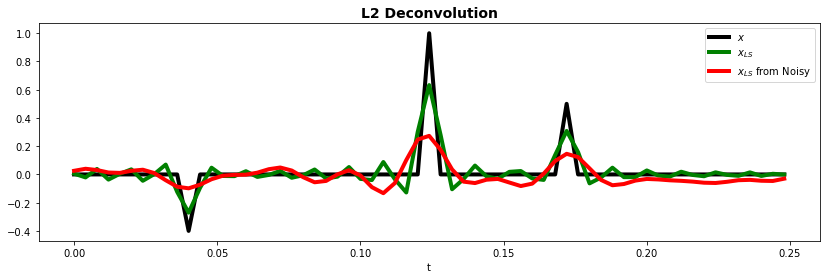

In [8]:
# Quickest way (no control)
#xls = Cop / y
#xnls = Cop / yn

# Scipy lsqr (missing callback)
#xls = lsqr(Cop, y, damp=1e-10, iter_lim=1000, show=0)[0]
#xnls = lsqr(Cop, yn, damp=1e-1, iter_lim=1000, show=0)[0]

# Pylops slqr
errls, errnls = [], []
xls = lsqr_pylops(Cop, y, np.zeros(nt), damp=1e-10, atol=0, btol=0, niter=400, show=0, 
                  callback=lambda X: callback(X, x, errls))[0]
xnls = lsqr_pylops(Cop, yn, np.zeros(nt), damp=8e-1, atol=0, btol=0, niter=400, show=0, 
                   callback=lambda X: callback(X, x, errnls))[0]

# Regularized pylops wrapper
#xnls = pylops.optimization.leastsquares.RegularizedInversion(
#    Cop, [], yn, returninfo=False, **dict(damp=1e-1, atol=1e-3, iter_lim=100, show=0))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, xls, "g", lw=4, label=r"$x_{LS}$")
ax.plot(t, xnls, "r", lw=4, label=r"$x_{LS}$ from Noisy")
ax.set_xlabel("t")
ax.set_title("L2 Deconvolution", fontsize=14, fontweight="bold")
ax.legend();

Definitely a better result compared to the frequency domain case, especially for noisy data. However, we are still far from the true solution (black line).

### Equivalence between the least-squares solution and frequency domain decon

If we use periodic boundary conditions for the wavelet (acting as a filter on the reflectivity), then the convolutional operator $\mathbf{W}$ is a circular matrix. A nice property of circulant matrices is that they diagonalize under the Fourier transform, i.e.

$$
    \mathbf{F}\mathbf{W}\mathbf{F}^H = \mathbf{\Lambda},
$$

where $\mathbf{F}$ is the discrete Fourier transform, and $\mathbf{\Lambda}$ is a diagonal matrix containing the Fourier coefficients of the wavelet. In this specific case, since the wavelet is real and symmetric to the origin, we will see that the spectrum is also real and symmetric.

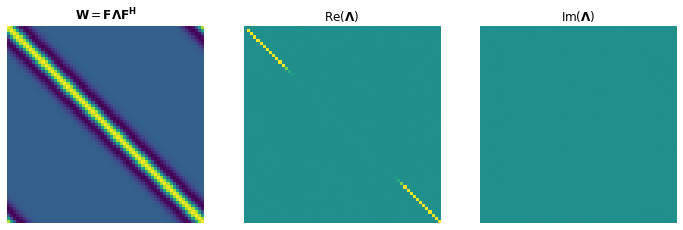

In [9]:
H = sp.linalg.circulant(np.fft.ifftshift(hfilt))
Hop = pylops.MatrixMult(H)
FFTop = pylops.signalprocessing.FFT(dims=nfft, nfft=nfft, sampling=dt, engine="numpy", dtype="complex128")

CopF = (FFTop @ Hop @ FFTop.H).todense()

fig, axs = plt.subplots(1, 3, figsize=(12, 12))
axs[0].imshow(H)
axs[0].set_title('$\mathbf{W} = \mathbf{F\Lambda F^H}$')
axs[0].axis('off')
axs[1].imshow(np.real(CopF), vmin=-0.2, vmax=0.2)
axs[1].set_title('Re($\mathbf{\Lambda}$)')
axs[1].axis('off')
axs[2].imshow(np.imag(CopF), vmin=-0.2, vmax=0.2)
axs[2].set_title('Im($\mathbf{\Lambda}$)')
axs[2].axis('off');

Recalling that the variational problem is solved by

$$
\mathbf{r}_{\lambda} = \left( \mathbf{W}^H\mathbf{W} + \lambda \mathbf{I}\right)^{-1}\mathbf{W}^H\mathbf{d},
$$

by plugging in $\mathbf{W} = \mathbf{F}^H\mathbf{\Lambda}\mathbf{F}$, we see that

$$
\mathbf{r}_{\lambda} = \mathbf{F}\left( \mathbf{\Lambda}^H\mathbf{\Lambda} + \lambda \mathbf{I}\right)^{-1}\mathbf{\Lambda}^H\mathbf{F}\mathbf{d},
$$

Hence, when solving the time domain problem we implicitely convert the data to the frequency domain, and filter the spectrum of the wavelet with the filter

$$
\varphi_{\lambda}(x) = \frac{x^*}{x^2 + \lambda} 
$$

The filter 

$$
\varphi_{\lambda}(x) = \frac{1}{x + \lambda} 
$$

corresponds to solving

$$
(\mathbf{W} + \lambda\mathbf{I})\mathbf{r} = \mathbf{d},
$$

in the time domain, which is known as Lavrentiev regularization. Finally, the filter 

$$
\varphi_{\lambda}(x) = \begin{cases} x \text{ if } x > \lambda \\ 0 \text{ if } x < \lambda \end{cases}
$$

corresponds to solving 

$$
    \mathbf{W}\mathbf{r} = \mathbf{d} 
$$

by simply cutting off the missing frequencies.


### Sparse solution

The result that we obtain using Tikhonov regularization is not very impressive, even more so in the presence of noise.

Luckily, we have a much stronger prior information that we can try to feed to our optimization. The sought reflectivity must be *sparse* (i.e., small number of non-zero elements in the solution). A large body of literature exists with respect to promotying sparsity in inverse problems. In general the problem to solve becomes
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wm}||_2^2 + \alpha ||\mathbf{m}||_p
$$

with $p \leq 1$. More specifically, $p=0$ ($L_0$ norm) and $p=1$ ($L_1$ norm) are the most commonly used norms. In the former case, solving the inverse problem is very hard and generally can only be done combinatorially with greedy algorithms. The second case can be seen as a relaxed version of the first and can be solved with iterative algorithms similar to those employed for least-squares inversion. In the following we will consider:
   
- Orthogonal Matching Pursuit (OMP)
- Iterative Shrinkage-Thresholding Algorithm (ISTA) and its faster variant Fast Iterative Shrinkage-Thresholding Algorithm (FISTA)

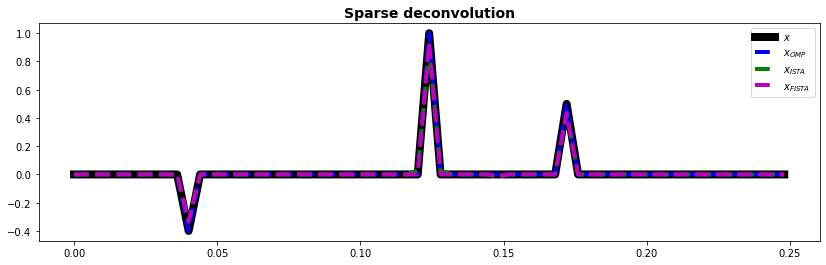

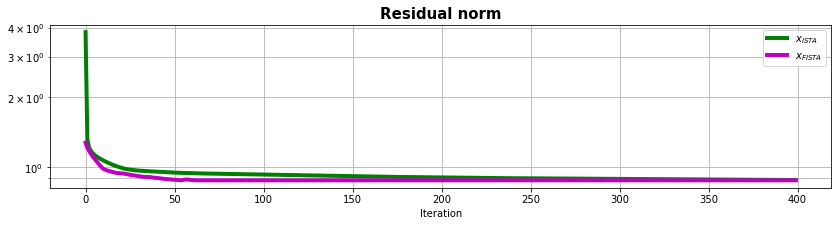

In [10]:
# noise-free
xomp, _, resomp = pylops.optimization.sparsity.OMP(
    Cop, y, niter_outer=10, sigma=1e-8)

errista, errfista = [], []
xista, _, resista = pylops.optimization.sparsity.ISTA(
    Cop, y, niter=400, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errista))

xfista, _, resfista = pylops.optimization.sparsity.FISTA(
    Cop, y, niter=400, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errfista))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xomp, "--b", lw=4, label=r"$x_{OMP}$")
ax.plot(t, xista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution", fontsize=14, fontweight="bold")
ax.legend();

fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.semilogy(resista, "g", lw=4, label=r"$x_{ISTA}$")
ax.semilogy(resfista, "m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Residual norm", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True, which="both")

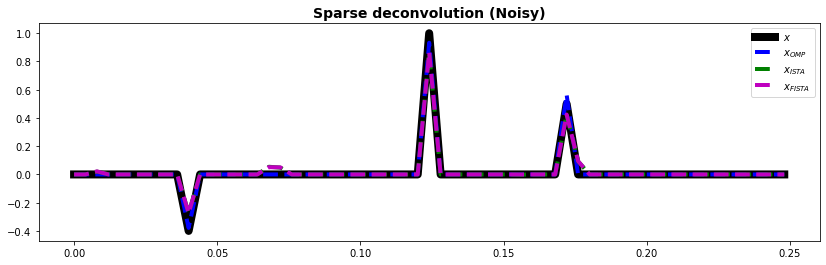

In [11]:
# noisy
xnomp, _, resomp = pylops.optimization.sparsity.OMP(
    Cop, yn, niter_outer=10, sigma=1e0, show=0)

errnista, errnfista = [], []
L = np.abs((Cop.H * Cop).eigs(1)[0])
xnista, _, resista = pylops.optimization.sparsity.ISTA(
    Cop, yn, niter=400, alpha=1./L, eps=5e-1, tol=1e-8, returninfo=True,
    callback=lambda X: callback(X, x, errnista))

xnfista, _, resfista = pylops.optimization.sparsity.FISTA(
    Cop, yn, niter=400, alpha=1./L, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errnfista))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xnomp, "--b", lw=4, label=r"$x_{OMP}$")
ax.plot(t, xnista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xnfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution (Noisy)", fontsize=14, fontweight="bold")
ax.legend();

#### Proximal algorithms

Up until now, we have not really discuss how ISTA (and FISTA) effectively work. These are specialized version of a family of solvers called **Proximal algorithms**.

Such solvers are particularly powerful as they can handle functional of the form:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{m})
$$

where $f$ is a smooth function (e.g., squared L2 norm) and $g$ is possibly non-smooth, convex function (e.g. L1 norm). The subfield of applied mathematics concerned with the solution of such problems is called *convex optimization*.

A general solution to this problem can be written as:

$$
\mathbf{m}_k = prox_{\alpha g} (\mathbf{m}_{k-1}-\alpha \nabla f(\mathbf{m}_{k-1}))\\
$$

where $prox_{\alpha g}$ is the so-called proximal operator of the function $g$. So provided we know how to evaluate the gradient of $f$ and the proximal of $g$ we can solve any problem with the same iterative scheme!

We have recently created a new library called [PyProximal](https://pyproximal.readthedocs.io) to ease the solution of convex optimization problems. As this library is fully integrated with PyLops, you can combine any of the linear operators in PyLops with any of the proximal operators in PyProximal. 

In [12]:
# noise-free
l1 = pyproximal.proximal.L1()
l2 = pyproximal.proximal.L2(Op=Cop, b=y)
L = np.abs((Cop.H * Cop).eigs(1)[0])
tau = 0.95/L
eps = 5e-1 * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5

errpista, errpfista = [], []
xista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), 
                epsg=eps, niter=400,
                callback=lambda X: callback(X, x, errpista))

xfista = pyproximal.optimization.primal.AcceleratedProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), acceleration='fista',
                epsg=eps, niter=200,
                callback=lambda X: callback(X, x, errpfista))

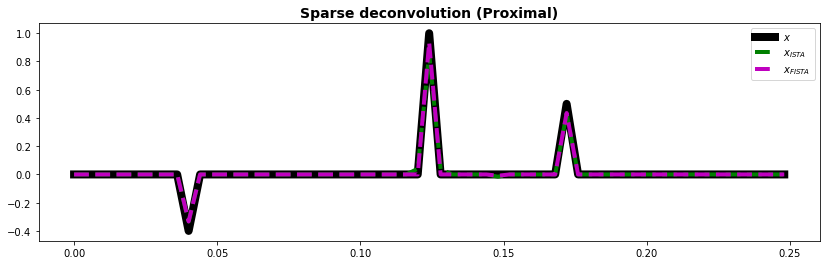

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution (Proximal)", fontsize=14, fontweight="bold")
ax.legend();

#### AFISTA

Sparse optimization problems are generally solved by applying an $\ell_1$ penalty because the resulting objective function is convex. However, if the solution is very sparse, non-convex regularization terms generally lead to faster convergence because of their propensity to even sparse solutions. One approach to do this is through Accelerated FISTA (AFISTA), which solves the following optimization problem:

$$
\underset{\mathbf{r}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wr}||_2^2 + \alpha ||\mathbf{D}\mathbf{r}||_1,
$$

where 

$$
    \mathbf{D} = \text{diag}\left(\frac{1}{\vert\mathbf{r}\vert}\right).
$$

This approach can be seen as adding a regularizer with the $\ell_0$ pseudo-norm. Indeed, 

$$
    \left\Vert \frac{\mathbf{r}}{\vert \mathbf{r}\vert}\right\Vert_1 = \Vert \mathbf{r}\Vert_0
$$

Because the true $\mathbf{r}$ is not known, this problem can not be solved. Therefore, the matrix $\mathbf{D}$ is approximated at every iteration by 

$$
    \mathbf{D}_k = \text{diag}\left(\frac{1}{\vert\mathbf{r}_k\vert}\right).
$$

This means that at every iteration the $\ell_0$ psuedo-norm is approximated.


In [14]:
xafista, errafista, resafista = AFISTA(Cop, y, niter=400, alpha=tau, eps=5e-2, x_true=x, delta=1e-2) 
xnafista, errnafista, resnafista = AFISTA(Cop, yn, niter=400, alpha=tau, eps=5e-2, x_true=x, delta=1e-2) 

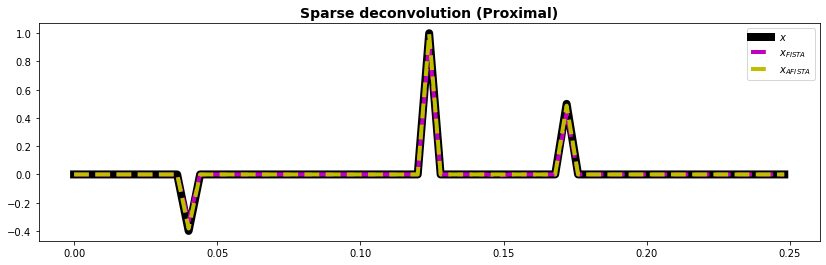

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.plot(t, xafista, "--y", lw=4, label=r"$x_{AFISTA}$")
ax.plot
ax.set_title("Sparse deconvolution (Proximal)", fontsize=14, fontweight="bold")
ax.legend();

And finally we compare the error norm as function of iteration for the different algorithms. This does not only tell us which solver produced the best solution but also what is their associated rate of convergence

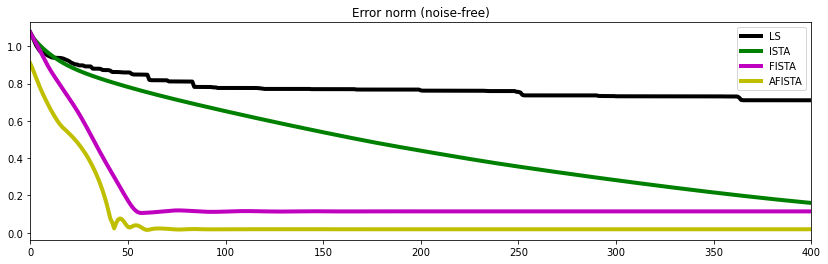

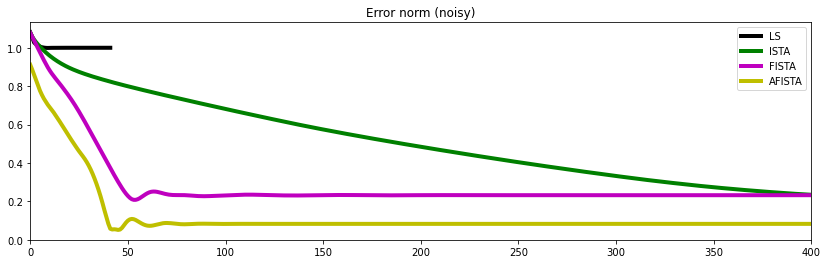

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(errls, 'k', lw=4, label='LS')
plt.plot(errista, 'g', lw=4, label='ISTA')
plt.plot(errfista, 'm', lw=4, label='FISTA')
plt.plot(errafista, 'y', lw=4, label='AFISTA')
ax.set_title('Error norm (noise-free)')
ax.set_xlim(0, 400)
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(errnls, 'k',lw=4, label='LS')
plt.plot(errnista, 'g', lw=4, label='ISTA')
plt.plot(errnfista, 'm', lw=4, label='FISTA')
plt.plot(errnafista, 'y', lw=4, label='AFISTA')
ax.set_title('Error norm (noisy)')
ax.set_xlim(0, 400)
ax.legend();

## Autograd-style inversion

Up until now we have used specialized algorithms such LSQR or FISTA and chosen the most appopriate one based on the functional that we wanted to optimize.

Nowadays, deep learning frameworks such as [PyTorch](https://pytorch.org) (or Tensorflow, JAX, etc.) provide us with an other appealing alternative, the so-called Automatic Differentiation (AD). In a nutshell, AD allows user to simply focus on the definition of a problem and implementation of its forward model and cost function; AD will provide the associated gradient!

In some cases this may raise the question: do we still need specialized optimizers or can we not simply used the gradient descent (GD) algorithm to solve every problem. In the following we want to show how the seismic deconvolution problem can be simply solved using the combination of AD and GD. Nevertheless, the convergence speed and quality of results are not surprisingly poorer than those we obtained so far.

As part of this exercise, we will rely on the PyLops operator `Convolve1D` to convolve the model with the known wavelet and we will wrap this into a `TorchOperator` object (from the [pylops-gpu](http://github.com/pyLops/pylops-gpu) library) that allows embedding a PyLops operator into a chain of PyTorch operators (and get AD for free).

### Unregularized

In [17]:
# Operator (we use TorchOperator from pylops-gpu to get our convolution operator into torch autograd chain!)
Cop_torch = TorchOperator(Cop, pylops=True)

# Data
ytorch = torch.from_numpy(y).float()

# Model
xad = torch.zeros(nt, dtype=torch.float)
xad.requires_grad = True

# Optimizer and Scheduler
optimizer = torch.optim.SGD([xad], lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

# Optimization without regularization
niters = 10000
eps = 1e-2
resad = []
for i in range(niters):
    optimizer.zero_grad()
    # forward
    yad = Cop_torch.apply(xad)
    # loss
    loss = torch.mean((ytorch-yad)**2)
    loss.backward()
    optimizer.step()
        
    # update learning rate
    if scheduler is not None:
        scheduler.step(loss)
    
    # logging
    resad.append(loss.item())
    if i % 1000 == 99:
        print(f'Iteration {i}, Functional value: {loss.item():.5f}')

Iteration 99, Functional value: 0.02567
Iteration 1099, Functional value: 0.00163
Iteration 2099, Functional value: 0.00090
Iteration 3099, Functional value: 0.00056
Iteration 4099, Functional value: 0.00038
Iteration 5099, Functional value: 0.00028
Iteration 6099, Functional value: 0.00021
Iteration 7099, Functional value: 0.00017
Iteration 8099, Functional value: 0.00014
Iteration 9099, Functional value: 0.00012


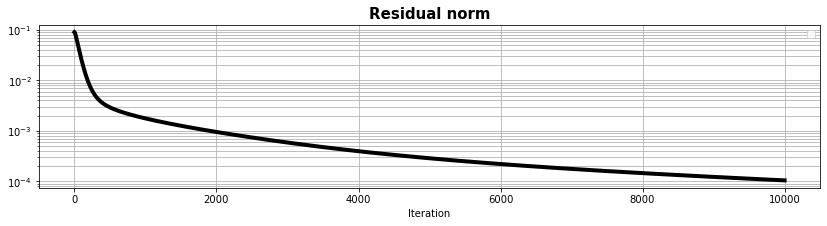

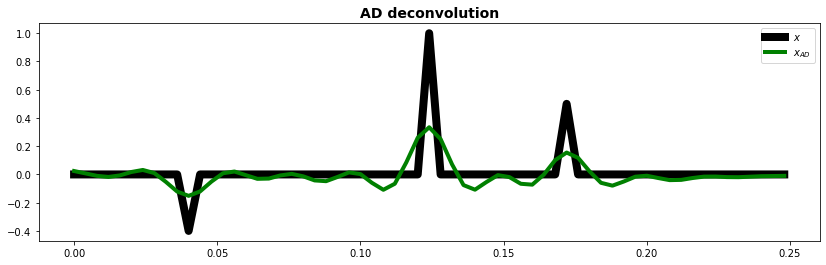

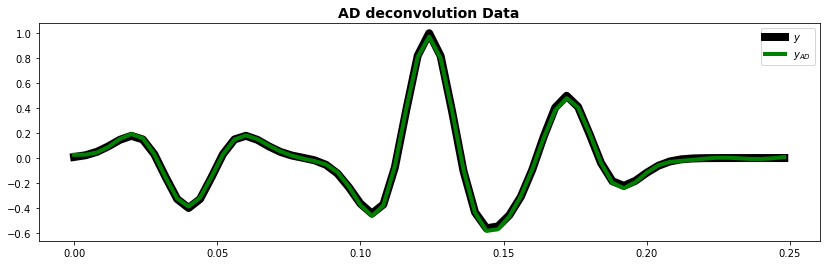

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.semilogy(resad, "k", lw=4)
ax.set_title("Residual norm", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True, which="both")

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xad.detach().numpy(), "g", lw=4, label=r"$x_{AD}$")
ax.set_title("AD deconvolution", fontsize=14, fontweight="bold")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y, "k", lw=8, label=r"$y$")
ax.plot(t, yad.detach().numpy(), "g", lw=4, label=r"$y_{AD}$")
ax.set_title("AD deconvolution Data", fontsize=14, fontweight="bold")
ax.legend()
ax.legend();

### L1 regularized

Let's now repeat the same exercise adding a $L_1$ regularization term. Here we are considering a edge case for AD as the $L_1$ is technically not differentiable (or at least around $x=0$). 

However, since it is rarely the case in numerical solutions that we will end up at $x=0$, PyTorch still provides AD for such a norm. However, to ensure convergence we reduce the learning rate gradually via and `ExponentialLR` scheduler.

In [19]:
# Data
ytorch = torch.from_numpy(y).float()

# Model
xad1 = torch.zeros(nt, dtype=torch.float)
xad1.requires_grad = True

# Optimizer
optimizer = torch.optim.SGD([xad1], lr=1e-1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, verbose=False)

# Optimization with L1 norm
niters = 50000
eps = 1e-2
resad1 = []
errad1 = []
for i in range(niters):
    optimizer.zero_grad()
    # forward
    yad1 = Cop_torch.apply(xad1)
    # data term
    lossd = torch.mean((ytorch-yad1)**2)
    # L1 reg
    reg = torch.sum(torch.abs(xad1))
    # total loss
    loss = lossd + eps * reg
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        errad1.append(np.linalg.norm(x-xad1.detach().numpy()))
    
    # update learning rate
    if scheduler is not None:
        scheduler.step(loss)
    
    # logging
    resad1.append(lossd.item())
    if i % 10000 == 0:
        print(f'Iteration {i}, Functional value: {loss.item():.5f}')

Iteration 0, Functional value: 0.09023
Iteration 10000, Functional value: 0.01840
Iteration 20000, Functional value: 0.01833
Iteration 30000, Functional value: 0.01835
Iteration 40000, Functional value: 0.01834


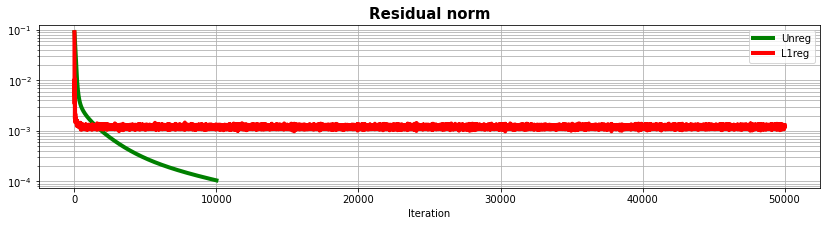

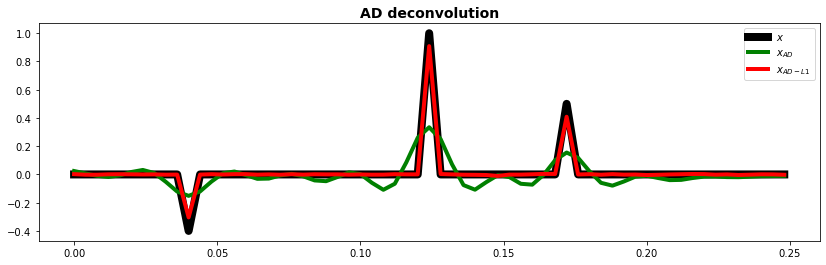

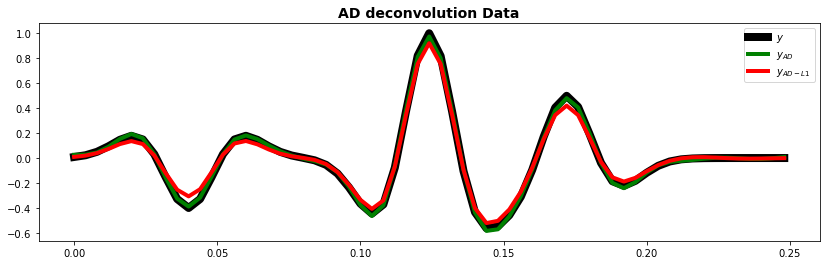

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.semilogy(resad, "g", lw=4, label='Unreg')
ax.semilogy(resad1, "r", lw=4, label='L1reg')
ax.set_title("Residual norm", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True, which="both")

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xad.detach().numpy(), "g", lw=4, label=r"$x_{AD}$")
ax.plot(t, xad1.detach().numpy(), "r", lw=4, label=r"$x_{AD-L1}$")
ax.set_title("AD deconvolution", fontsize=14, fontweight="bold")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y, "k", lw=8, label=r"$y$")
ax.plot(t, yad.detach().numpy(), "g", lw=4, label=r"$y_{AD}$")
ax.plot(t, yad1.detach().numpy(), "r", lw=4, label=r"$y_{AD-L1}$")
ax.set_title("AD deconvolution Data", fontsize=14, fontweight="bold")
ax.legend();

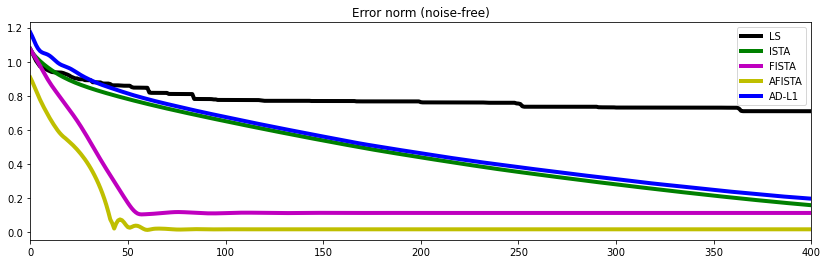

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(errls, 'k', lw=4, label='LS')
plt.plot(errista, 'g', lw=4, label='ISTA')
plt.plot(errfista, 'm', lw=4, label='FISTA')
plt.plot(errafista, 'y', lw=4, label='AFISTA')
plt.plot(errad1, 'b', lw=4, label='AD-L1')
ax.set_title('Error norm (noise-free)')
ax.set_xlim(0, 400)
ax.legend();

## Deep Image Prior 

Our final example where we assume knowledge of the modelling operator will act as a bridge towards full model-based and data-driven methods to deconvolution.

In this case we will try to leverage the concept of Deep Image Prior introduced by Ulyanov and colleages in 2017 ([link](https://arxiv.org/abs/1711.10925)). The key idea of this method is that even in the absence of training data, the power of NNs could be leveraged when solving inverse problems. This is achieved by optimizing the parameters of an untrained NN instead of the reflectivity when solving the inverse problem. Mathematically speaking we wish to solve:

$$
\underset{\theta} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{W}f_\theta(\mathbf{w})||_2^2
$$

where $\mathbf{w}$ is a vector containing random numbers drawn from a normal distribution, and $\theta$ refers the parameters of the network.

It turns out that for a problem of this kind, DIP is not a good enough prior. The network will converge to something that produces a reflectivity matching the data but far away from the 3 spike solution we are after. Eventually, we can add once again our sparsity regularization term

$$
\underset{\theta} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{W}f_\theta(\mathbf{w})||_2^2 + \alpha ||f_\theta(\mathbf{w})||_1
$$

this time we will get a good solution. Feel free to play with $\alpha$ and observe how influential it is in this case!

In [22]:
# Redifine time axis (multiple of 2)
nt = 64
t = np.arange(nt) * dt

# Operator
Cop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
Cop_torch = TorchOperator(Cop, pylops=True)

# Data
y = Cop * np.pad(x, (0 ,1))
ytorch = torch.from_numpy(y).float()

In [23]:
# Network
network = UNet(1, 1, hidden_channels=32, levels=2)
network.apply(init_weights)

# Optimizer
lr = 1e-4
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.995, verbose=False)

# Input
noise = 3*torch.randn(nt, dtype=torch.float32)

niters = 6000
alpha = 1e-4 # try 0
resdip = []
l1dip = []
errdip = []
for i in range(niters):
    optimizer.zero_grad()
    # forward
    xdip = network(noise.unsqueeze(0).unsqueeze(0)).squeeze()
    ydip = Cop_torch.apply(xdip)
    
    # loss
    if alpha == 0.:
        loss = torch.mean((ytorch-ydip)**2)
    else:
        # data term
        lossd = torch.mean((ytorch-ydip)**2)
        # L1 reg
        reg = torch.sum(torch.abs(xdip))
        # total loss
        loss = lossd + alpha * reg
    loss.backward()
    optimizer.step()
    
    # error
    with torch.no_grad():
        errdip.append(np.linalg.norm(x-xdip[:-1].detach().numpy()))
    
    # update learning rate
    if scheduler is not None:
        scheduler.step()
    
    # logging
    resdip.append(lossd.item())
    if alpha > 0.:
        l1dip.append(reg.item())
    if i % 1000 == 0:
        print(f'Iteration {i}, Functional value: {loss.item():.5f}')
    """
    if i % 2000 == 0:
        fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        ax.plot(t[:-1], x, "k", lw=8, label=r"$x$")
        ax.plot(t, xdip.detach().numpy(), "#FFA500", lw=4, label=r"$x_{DIP}$")
        ax.set_title("DIP deconvolution", fontsize=14, fontweight="bold")
        ax.legend()
        plt.show()
    """

Iteration 0, Functional value: 0.53342
Iteration 1000, Functional value: 0.00024
Iteration 2000, Functional value: 0.00020
Iteration 3000, Functional value: 0.00020
Iteration 4000, Functional value: 0.00020
Iteration 5000, Functional value: 0.00022


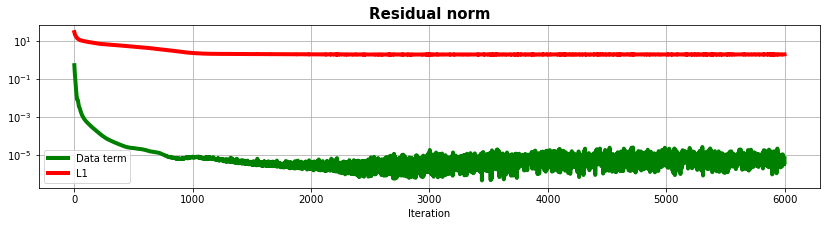

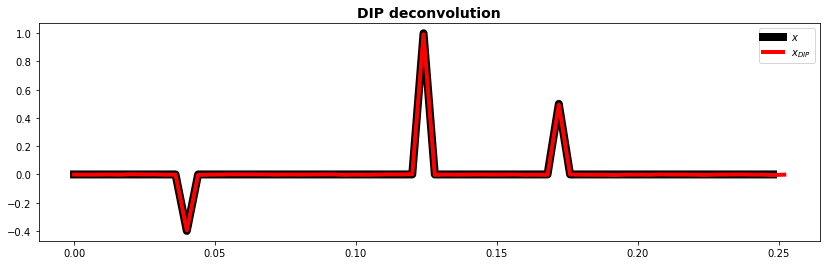

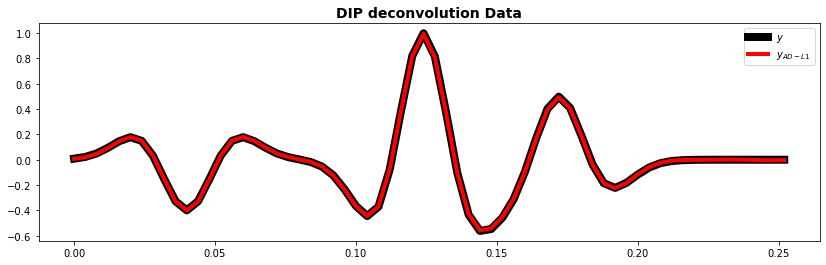

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.semilogy(resdip, "g", lw=4, label='Data term')
ax.semilogy(l1dip, "r", lw=4, label='L1')
ax.set_title("Residual norm", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True, which="both")

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t[:-1], x, "k", lw=8, label=r"$x$")
ax.plot(t, xdip.detach().numpy(), "r", lw=4, label=r"$x_{DIP}$")
ax.set_title("DIP deconvolution", fontsize=14, fontweight="bold")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y, "k", lw=8, label=r"$y$")
ax.plot(t, ydip.detach().numpy(), "r", lw=4, label=r"$y_{AD-L1}$")
ax.set_title("DIP deconvolution Data", fontsize=14, fontweight="bold")
ax.legend();

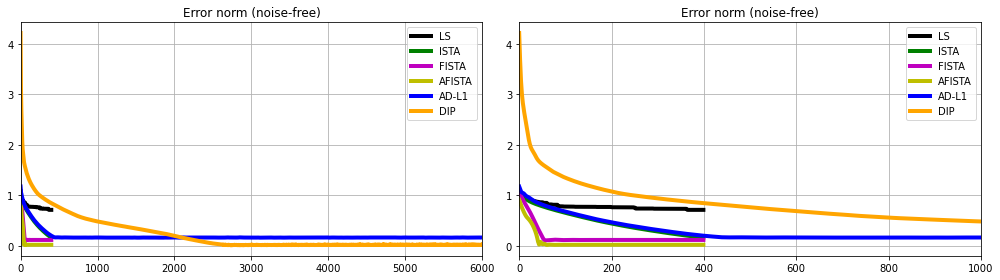

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
for ax in axs:
    ax.plot(errls, 'k', lw=4, label='LS')
    ax.plot(errista, 'g', lw=4, label='ISTA')
    ax.plot(errfista, 'm', lw=4, label='FISTA')
    ax.plot(errafista, 'y', lw=4, label='AFISTA')
    ax.plot(errad1, 'b', lw=4, label='AD-L1')
    ax.plot(errdip, '#FFA500', lw=4, label='DIP')
    ax.set_title('Error norm (noise-free)')
    ax.legend()
    ax.grid()
axs[0].set_xlim(0, 6000)
axs[1].set_xlim(0, 1000)
plt.tight_layout()

## Data-driven

Last but not least, what about taking a purely data-driven approach. Here we assume that we do not know directly the modelling operator, rather that we can create synthetically (or have direct access to) a large set of reflectivity/band-limited data pairs.

In other words, given a set of N reflectivities:

$$
\mathbf{R} = \{ \mathbf{r}_1, \mathbf{r}_2, ..., \mathbf{r}_N \}
$$

and the associated data (with fixed wavelet $w$ and no noise)

$$
\mathbf{D} = \{ \mathbf{d}_1, \mathbf{d}_2, ..., \mathbf{d}_N \}
$$

a data-driven approach can be defined as follows:

$$
\mathbf{m}_i = f_\theta(\mathbf{d}_i) \; \forall i
$$

or in other words, a model $f_\theta$ with parameters $\theta$ is defined to map data into reflectivities and the $\theta$ parameters are learned by minimizing the different between the true and predicted reflectivity:

$$
\underset{\theta} {\mathrm{argmin}} \sum_{i=1}^{N} ||\mathbf{r}_i - f_\theta(\mathbf{d}_i)||_p
$$

The success of this learning process heavily depends on the selection of the model $f_\theta$: in the following we will use a neural network and more specifically a 1D-UNET architecture.

Let's start by creating a dataset composed of 256 training samples and 10 testing samples. 

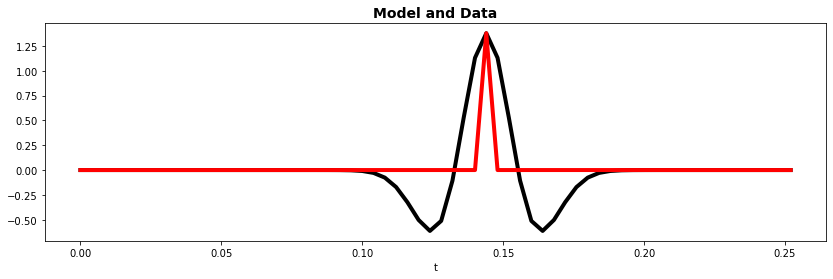

In [26]:
set_seed(0)

# Train data
ntrain = 2**8
X_train = np.zeros((ntrain, nt))
y_train = np.zeros((ntrain, nt))
for i in range(ntrain):
    y_train[i], X_train[i] = create_reflectivity_and_data((1,4), 2, nt=nt, twav=t[:101], f0=f0)
    
# Test data
ntrain = 10
X_test = np.zeros((ntrain, nt))
y_test = np.zeros((ntrain, nt))
for i in range(ntrain):
    y_test[i], X_test[i] = create_reflectivity_and_data((1,4), 2, nt=nt, twav=t[:101], f0=f0)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, X_train[0].T, "k", lw=4)
ax.plot(t, y_train[0].T, "r", lw=4)
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold");

In [27]:
# Convert Train Set to Torch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
train_dataset = TensorDataset(X_train, y_train)

# Convert Test Set to Torch
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
test_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches.
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [28]:
network = UNet(1, 1, hidden_channels=32)
#network = network.apply(weights_init) 
#print(network)

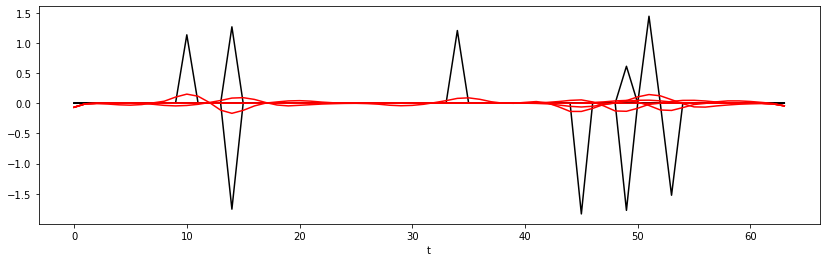

Epoch 0, Training Loss 0.05, Test Loss 0.04


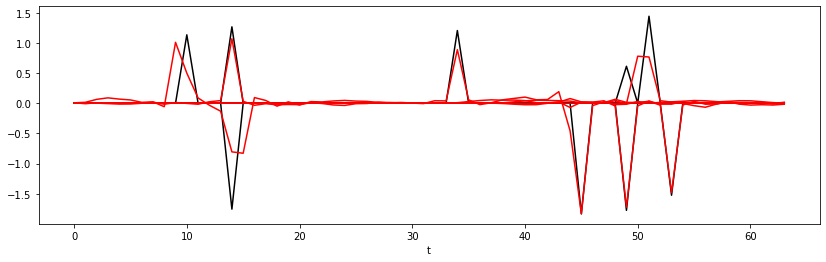

Epoch 25, Training Loss 0.01, Test Loss 0.01


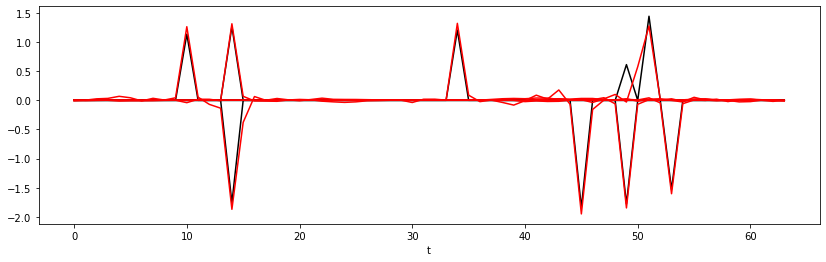

Epoch 50, Training Loss 0.01, Test Loss 0.00


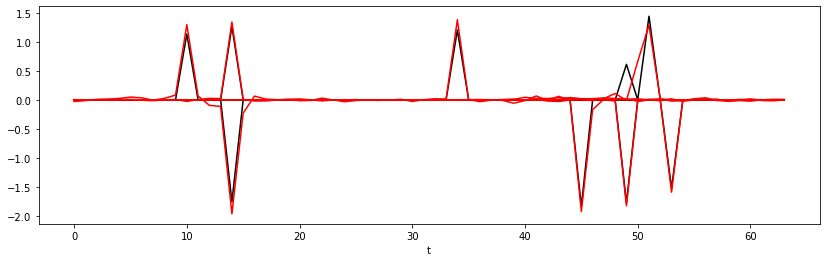

Epoch 75, Training Loss 0.00, Test Loss 0.00


In [29]:
n_epochs = 100
lr = 1e-3

criterion = nn.MSELoss()
optim = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=1e-4)

train_loss_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
for i in range(n_epochs):
    train_loss = train(network, criterion, optim, 
                       train_loader, device='cpu', 
                       plotflag=False)
    test_loss = evaluate(network, criterion, 
                         test_loader, device='cpu', 
                         plotflag=True if i%25==0 else False)
    train_loss_history[i]= train_loss
    test_loss_history[i] = test_loss
    if i % 25 == 0:
        print(f'Epoch {i}, Training Loss {train_loss:.2f}, Test Loss {test_loss:.2f}')

Let's finally display the training and test losses and a set of predictions both for training and test data

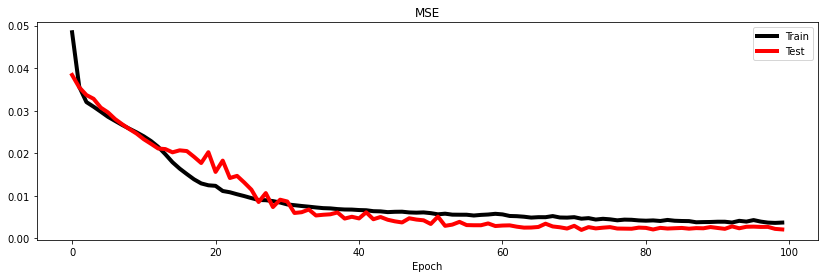

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(train_loss_history, "k", lw=4, label='Train')
ax.plot(test_loss_history, "r", lw=4, label='Test')
ax.set_title('MSE')
ax.set_xlabel('Epoch')
ax.legend();

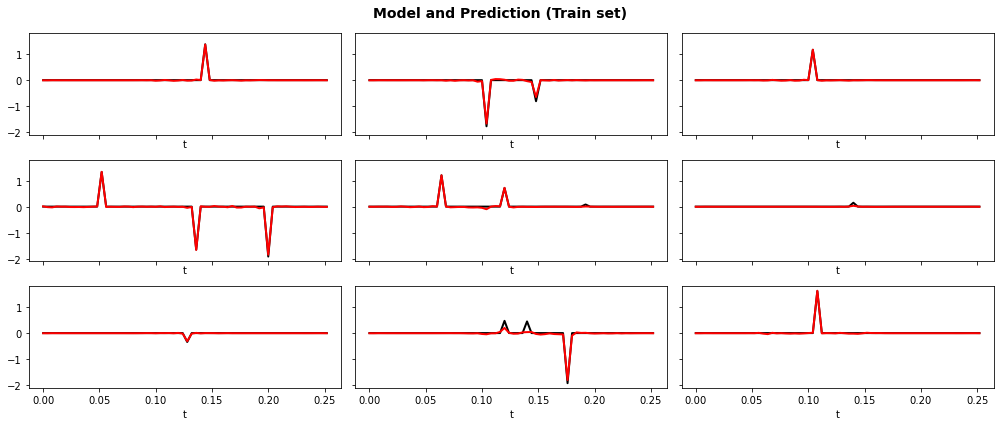

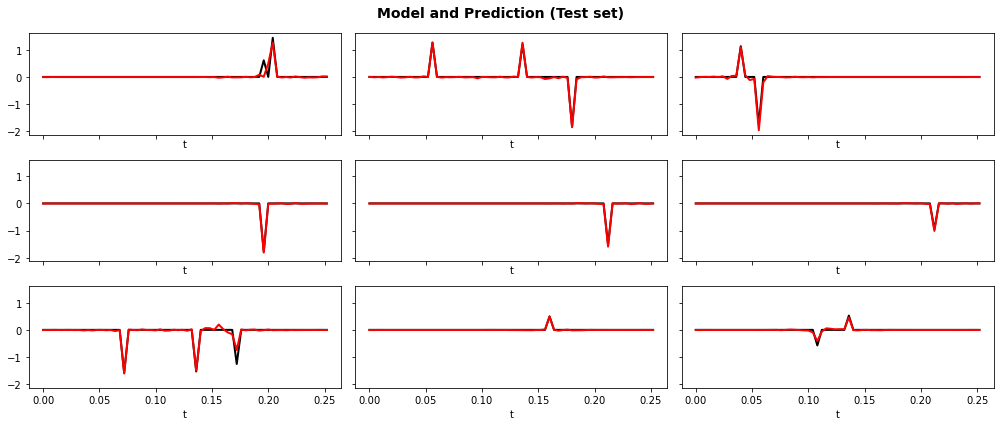

In [31]:
y_train_pred = predict(network, X_train[:10].unsqueeze(1), device='cpu').squeeze()
y_test_pred = predict(network, X_test[:10].unsqueeze(1), device='cpu').squeeze()

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(14, 6))
fig.suptitle("Model and Prediction (Train set)", fontsize=14, fontweight="bold")
axs = axs.ravel()
for iax, ax in enumerate(axs):
    ax.plot(t, y_train[iax].T, "k", lw=2)
    ax.plot(t, y_train_pred[iax].T, "r", lw=2)
    ax.set_xlabel("t")   
plt.tight_layout()

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(14, 6))
fig.suptitle("Model and Prediction (Test set)", fontsize=14, fontweight="bold")
axs = axs.ravel()
for iax, ax in enumerate(axs):
    ax.plot(t, y_test[iax].T, "k", lw=2)
    ax.plot(t, y_test_pred[iax].T, "r", lw=2)
    ax.set_xlabel("t")   
plt.tight_layout()

And finally let's see how the trained model performs on the data that we have used in all other examples

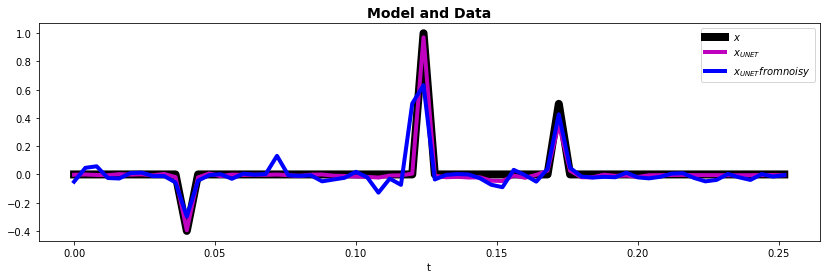

In [32]:
# We just need to pad y and yn by one sample
x = np.pad(x, (0, 1))

x_pred = predict(network, torch.from_numpy(y).unsqueeze(0).unsqueeze(0).float(), device='cpu').squeeze()
xn_pred = predict(network, torch.from_numpy(np.pad(yn, (0,1))).unsqueeze(0).unsqueeze(0).float(), device='cpu').squeeze()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, x_pred, "m", lw=4, label=r"$x_{UNET}$")
ax.plot(t, xn_pred, "b", lw=4, label=r"$x_{UNET} from noisy$")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold")
ax.legend();

## Conclusions

Wavelet deconvolution is a well-known and well-studied problem in signal processing and geophysics. 

This problem is however still of interest nowadays because of the fact that it is an extremely ill-posed inverse problem. In other words, given a wavelet with a limited bandwidth, the part of the reflectivity that lies outside of such bandwidth cannot be directly recovered from the recorded data. Prior information in the form of regularization (in classical optimization) or training data (in data-driven optimization) is therefore required.

In this tour, we have looked at various alternative approaches to deconvolution and discussed how different libraries in the Python ecosystem can help us implement and compare such approaches. Our conclusion is that there is no winner and loser: each method has a place depending on the time and effort (both human and computational) you would like to put into solving the deconvolution problem. 

This highlight the fact that a *one-for-all algorithm* does not exist in the field of mathematical optimization. You could always use the same solver, but be aware that hardly this will always outperform other algorithms!